Using device: cuda
[TOTAL COMBINED POOL] Total Images: 6746


Downloading: "https://download.pytorch.org/models/swin_b-68c6b09e.pth" to /root/.cache/torch/hub/checkpoints/swin_b-68c6b09e.pth
100%|██████████| 335M/335M [00:01<00:00, 228MB/s] 



--- Starting Swin-B Feature Extraction ---


Feature Extraction:   0%|          | 0/338 [00:00<?, ?it/s]

Feature Extraction:   0%|          | 0/43 [00:00<?, ?it/s]

Feature Extraction:   0%|          | 0/43 [00:00<?, ?it/s]

Training features shape: (5396, 1024) | Combined train size: 5396

#####################################################
--- 1. Optimizing Support Vector Machine (SVC) ---
#####################################################
SVM {'svc__C': 1.0, 'svc__kernel': 'linear'}: CV F1 = 0.9140
SVM {'svc__C': 10.0, 'svc__kernel': 'linear'}: CV F1 = 0.9125
SVM {'svc__C': 100.0, 'svc__kernel': 'linear'}: CV F1 = 0.9125
SVM {'svc__C': 10.0, 'svc__kernel': 'rbf'}: CV F1 = 0.9682
Chosen SVM: {'svc__C': 10.0, 'svc__kernel': 'rbf'} | CV F1: 0.9682

#####################################################
--- 2. Optimizing Random Forest Classifier (RF) ---
#####################################################
RF {'n_estimators': 100, 'max_depth': 10}: CV F1 = 0.8721
RF {'n_estimators': 300, 'max_depth': 20}: CV F1 = 0.9146
RF {'n_estimators': 500, 'max_depth': 30}: CV F1 = 0.9159
RF {'n_estimators': 700, 'max_depth': None}: CV F1 = 0.9163
Chosen RF: {'n_estimators': 700, 'max_depth': None} | CV F1: 0.9163

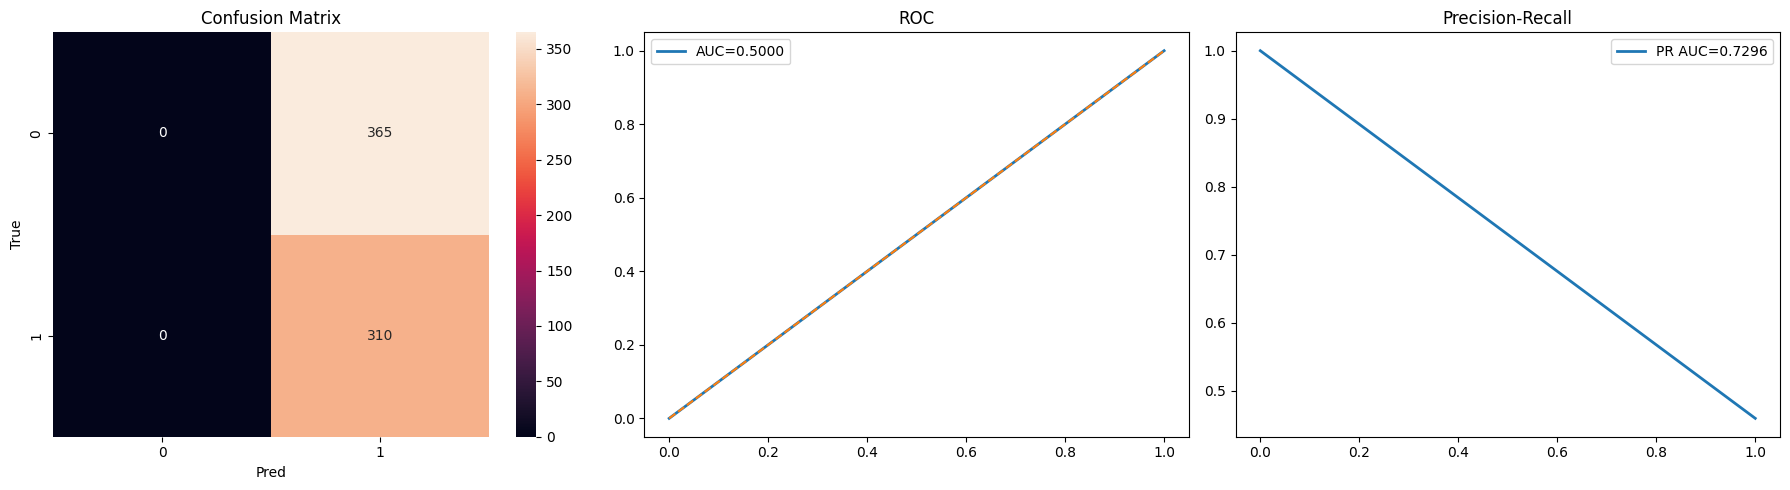


--- BEST Random Forest (Config: {'n_estimators': 700, 'max_depth': None}) ---
Optimal Threshold: 0.59
F1: 0.9470 | Acc: 0.9526 | Rec: 0.9226 | Prec: 0.9728
Confusion Matrix:
 [[357   8]
 [ 24 286]]


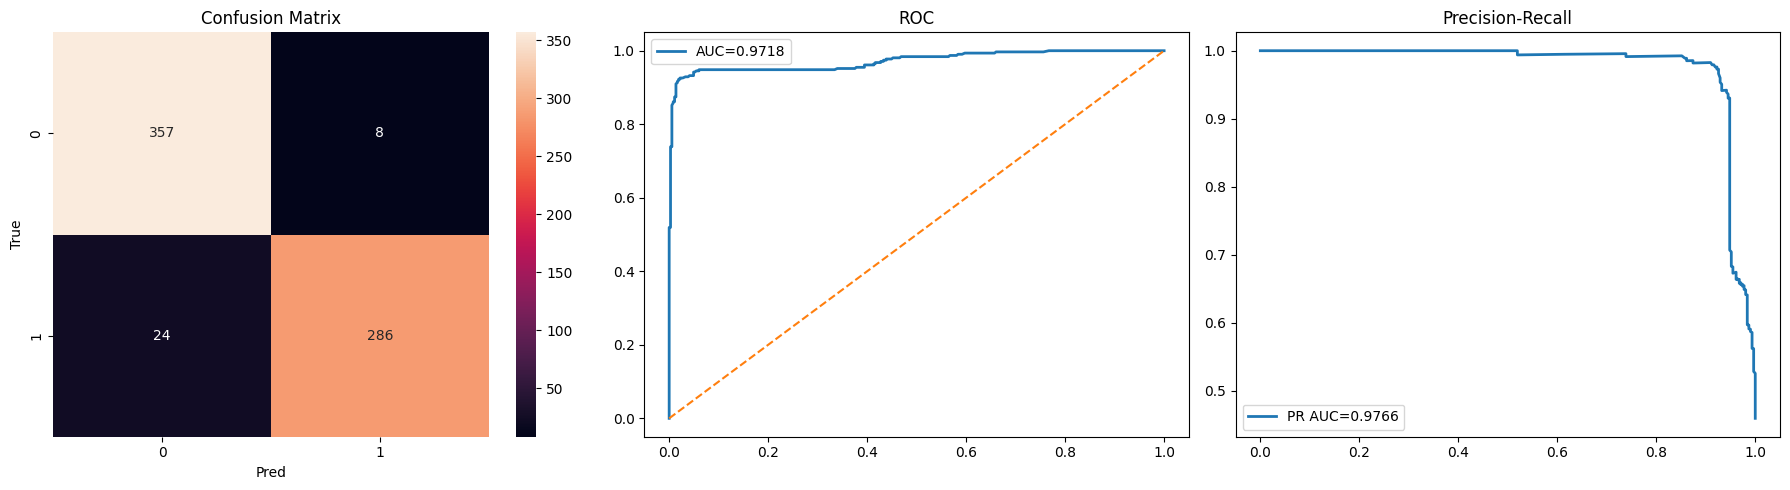


--- BEST MLP (ANN) (Config: {'hidden_layer_sizes': (1024, 512), 'alpha': 0.001}) ---
Optimal Threshold: 0.42
F1: 0.9673 | Acc: 0.9704 | Rec: 0.9548 | Prec: 0.9801
Confusion Matrix:
 [[359   6]
 [ 14 296]]


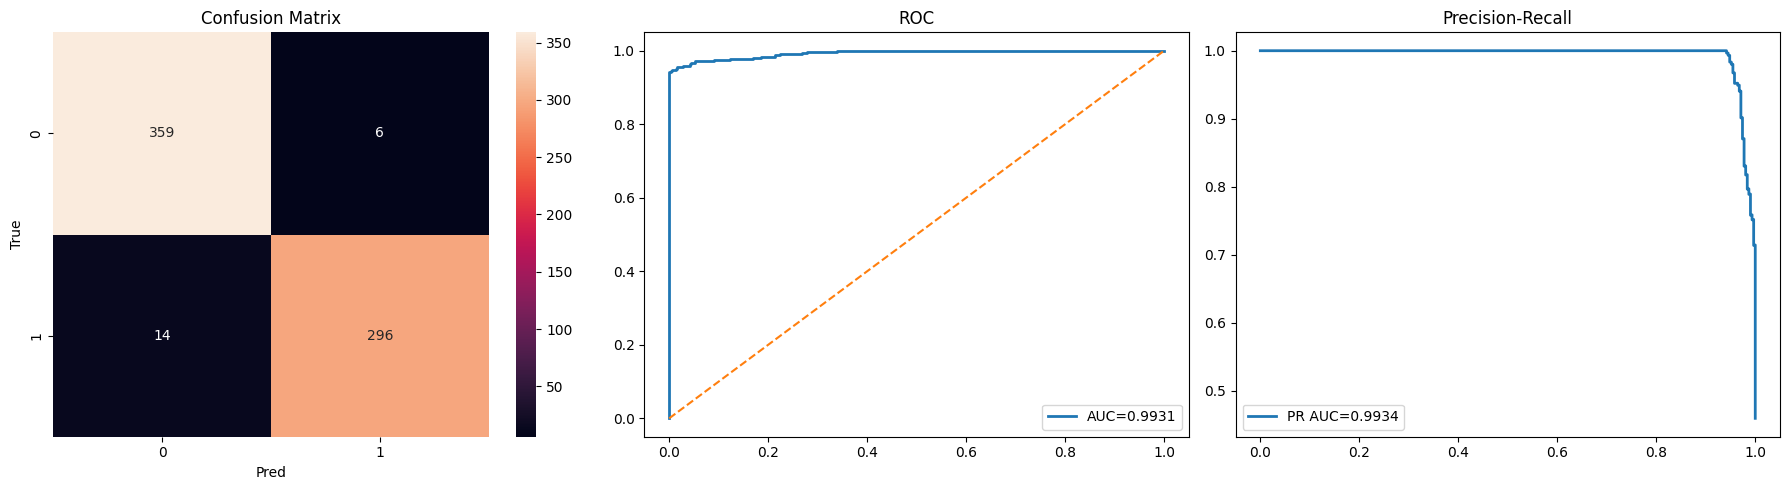


--- Ensemble (RF+MLP) (Config: RF+MLP average) ---
Optimal Threshold: 0.68
F1: 0.9668 | Acc: 0.9704 | Rec: 0.9387 | Prec: 0.9966
Confusion Matrix:
 [[364   1]
 [ 19 291]]


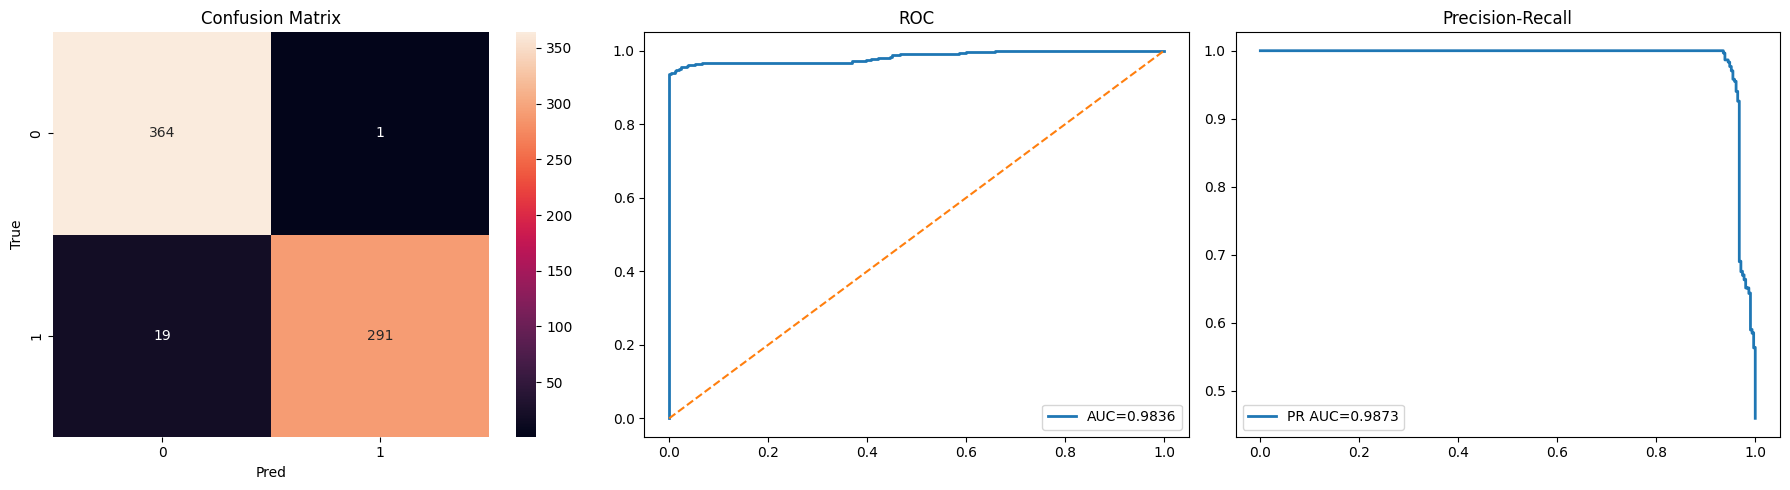


=== Summary of Test F1 scores ===
SVM: F1 = 0.6294
Random Forest: F1 = 0.9470
MLP (ANN): F1 = 0.9673
Ensemble_RF_MLP: F1 = 0.9668
Saved SVM to /kaggle/working/models
Saved Random Forest to /kaggle/working/models
Saved MLP (ANN) to /kaggle/working/models


In [1]:
# FINAL COMPLETE SCRIPT: Optimized Models with CORRECTED Swin-B Features (1024 Dimensions)
# Fix applied: FeatureSwin class now correctly extracts the 1024-dimensional vector by stripping the classification head.

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
import logging

# sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve, make_scorer
)
from sklearn.pipeline import Pipeline

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import swin_b
from tqdm.auto import tqdm

warnings.filterwarnings('ignore')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# ---------- Paths & constants ----------
ROBOFLOW_BASE_PATH = '/kaggle/input/universe-roboflow'
NEW_DATA_BASE_PATH = '/kaggle/input/new-new'
BIRAD_MAPPING = {'BIRAD1': 0, 'Birad3': 0, 'Birad4': 1, 'Birad5': 1}
IMAGE_SIZE = 224

# ---------- Helpers ----------
def load_all_data(roboflow_path, new_data_path, birad_map):
    all_paths, all_labels = [], []
    for split in ['train', 'valid', 'test']:
        for label_name, label_id in [('Benign', 0), ('Malignant', 1)]:
            dir_path = os.path.join(roboflow_path, split, label_name)
            if os.path.exists(dir_path):
                for dirpath, _, filenames in os.walk(dir_path):
                    for file in filenames:
                        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                            all_paths.append(os.path.join(dirpath, file))
                            all_labels.append(label_id)

    for folder_name, label_id in birad_map.items():
        # FIX: Correctly using the function argument 'new_data_path'
        root_dir = os.path.join(new_data_path, folder_name)
        if os.path.exists(root_dir):
            for dirpath, _, filenames in os.walk(root_dir):
                for file in filenames:
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        all_paths.append(os.path.join(dirpath, file))
                        all_labels.append(label_id)

    if len(all_paths) == 0:
        raise RuntimeError("No images found. Check dataset paths.")

    valid_indices = [i for i, label in enumerate(all_labels) if label in (0, 1)]
    all_paths = [all_paths[i] for i in valid_indices]
    all_labels = [all_labels[i] for i in valid_indices]
    print(f"[TOTAL COMBINED POOL] Total Images: {len(all_paths)}")
    return all_paths, all_labels

class UltrasoundDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        try:
            img = Image.open(p).convert('RGB')
        except Exception:
            img = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE), 'white')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

# --- CORRECTED FEATURE EXTRACTOR ---
class FeatureSwin(nn.Module):
    def __init__(self):
        super().__init__()
        swin_model = swin_b(weights='IMAGENET1K_V1')
        
        # FIX: Use sequential to strip the final linear classification layer ('head')
        # This ensures the output is the 1024-dimensional feature vector.
        self.feature_extractor = torch.nn.Sequential(*(list(swin_model.children())[:-1]))
        
        # freeze pretrained params
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.feature_extractor(x)
        # The output is (Batch, 1024, 1, 1). Flatten to (Batch, 1024).
        x = torch.flatten(x, 1)
        return x

def extract_features(model, loader, device):
    all_feats, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="Feature Extraction"):
            xb = xb.to(device)
            feats = model(xb)
            all_feats.append(feats.cpu().numpy())
            all_labels.extend(yb.cpu().numpy() if isinstance(yb, torch.Tensor) else yb)
    if len(all_feats) == 0:
        return np.zeros((0, 0)), np.array([])
    return np.concatenate(all_feats, axis=0), np.array(all_labels)

def find_optimal_threshold(targets, probs):
    best_f1, best_t = 0.0, 0.5
    step = 0.01 if len(targets) > 500 else 0.05
    for t in np.arange(0.1, 0.9, step):
        preds = (probs > t).astype(int)
        f1 = f1_score(targets, preds, average='binary', zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

def print_and_plot_metrics(y_true, y_prob, final_model_name, path_suffix, config_info):
    opt_t, f1 = find_optimal_threshold(y_true, y_prob)
    y_pred_opt = (y_prob > opt_t).astype(int)

    acc = accuracy_score(y_true, y_pred_opt)
    rec = recall_score(y_true, y_pred_opt, average='binary', pos_label=1, zero_division=0)
    prec = precision_score(y_true, y_pred_opt, average='binary', pos_label=1, zero_division=0)
    cm = confusion_matrix(y_true, y_pred_opt)

    print(f"\n--- {final_model_name} (Config: {config_info}) ---")
    print(f"Optimal Threshold: {opt_t:.2f}")
    print(f"F1: {f1:.4f} | Acc: {acc:.4f} | Rec: {rec:.4f} | Prec: {prec:.4f}")
    print("Confusion Matrix:\n", cm)

    # plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0])
    axes[0].set_title('Confusion Matrix'); axes[0].set_xlabel('Pred'); axes[0].set_ylabel('True')

    try:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        axes[1].plot(fpr, tpr, lw=2, label=f'AUC={auc(fpr, tpr):.4f}')
        axes[1].plot([0,1],[0,1], ls='--')
        axes[1].set_title('ROC'); axes[1].legend()
    except Exception:
        axes[1].text(0.5, 0.5, "ROC n/a", ha='center')

    try:
        p_vals, r_vals, _ = precision_recall_curve(y_true, y_prob)
        axes[2].plot(r_vals, p_vals, lw=2, label=f'PR AUC={auc(r_vals, p_vals):.4f}')
        axes[2].set_title('Precision-Recall'); axes[2].legend()
    except Exception:
        axes[2].text(0.5, 0.5, "PR n/a", ha='center')

    plt.tight_layout()
    try:
        plt.savefig(f'/kaggle/working/{path_suffix}_metrics.png')
    except Exception:
        pass
    plt.show()
    return f1

# ----------------------------------------------------------------------------------
# --- EXECUTION START ---

# Load & split
all_paths, all_labels = load_all_data(ROBOFLOW_BASE_PATH, NEW_DATA_BASE_PATH, BIRAD_MAPPING)
X_train, X_tmp, y_train, y_tmp = train_test_split(all_paths, all_labels, test_size=0.20, random_state=42, stratify=all_labels)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=42, stratify=y_tmp)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BATCH_SIZE = 16
NUM_WORKERS = 4
pin_mem = torch.cuda.is_available() # Pin memory only if CUDA is available

train_loader = DataLoader(UltrasoundDataset(X_train, y_train, transform), batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=pin_mem)
val_loader   = DataLoader(UltrasoundDataset(X_val, y_val, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem)
test_loader  = DataLoader(UltrasoundDataset(X_test, y_test, transform), batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=pin_mem)

# Feature extraction
feature_model = FeatureSwin().to(device)
if torch.cuda.is_available(): torch.cuda.empty_cache()

print("\n--- Starting Swin-B Feature Extraction ---")
X_train_f, y_train_f = extract_features(feature_model, train_loader, device)
X_val_f, y_val_f     = extract_features(feature_model, val_loader, device)
X_test_f, y_test_f   = extract_features(feature_model, test_loader, device)

if X_train_f.size == 0:
    raise RuntimeError("No features extracted for training. Check feature extractor and dataset.")

print(f"Training features shape: {X_train_f.shape} | Combined train size: {len(X_train_f)}")

# --- Combine Training and Validation for ML Training ---
X_train_ml = np.concatenate([X_train_f, X_val_f], axis=0)
y_train_ml = np.concatenate([y_train_f, y_val_f], axis=0)

# --- Feature preparation for ML models ---
# No PCA applied, using full 1024 features
X_train_ml = X_train_ml.copy()
X_val_f_transformed = X_val_f.copy()
X_test_f_transformed = X_test_f.copy()

# ---------- Model selection & tuning (classical ML) ----------
best_models = {}
f1_scorer = make_scorer(f1_score, average='binary', zero_division=0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- SVM (scaled) ---
print("\n#####################################################")
print("--- 1. Optimizing Support Vector Machine (SVC) ---")
print("#####################################################")
svm_cfgs = [
    {'svc__C': 1.0, 'svc__kernel': 'linear'},
    {'svc__C': 10.0, 'svc__kernel': 'linear'},
    {'svc__C': 100.0, 'svc__kernel': 'linear'},
    {'svc__C': 10.0, 'svc__kernel': 'rbf'}
]
best_svm_f1, best_svm_cfg = -1.0, None
for cfg in svm_cfgs:
    pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True, random_state=42, class_weight='balanced'))])
    pipe.set_params(**cfg)
    # Using X_train_ml, y_train_ml (combined) for cross-validation for maximum data
    scores = cross_val_score(pipe, X_train_ml, y_train_ml, cv=cv, scoring=f1_scorer, n_jobs=-1)
    mean_f1 = scores.mean()
    print(f"SVM {cfg}: CV F1 = {mean_f1:.4f}")
    if mean_f1 > best_svm_f1:
        best_svm_f1, best_svm_cfg = mean_f1, cfg

best_svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True, random_state=42, class_weight='balanced'))])
best_svm_pipeline.set_params(**best_svm_cfg).fit(X_train_ml, y_train_ml)
best_models['SVM'] = {'model': best_svm_pipeline, 'f1': best_svm_f1, 'config': best_svm_cfg}
print(f"Chosen SVM: {best_svm_cfg} | CV F1: {best_svm_f1:.4f}")

# --- Random Forest ---
print("\n#####################################################")
print("--- 2. Optimizing Random Forest Classifier (RF) ---")
print("#####################################################")
rf_cfgs = [
    {'n_estimators': 100, 'max_depth': 10},
    {'n_estimators': 300, 'max_depth': 20},
    {'n_estimators': 500, 'max_depth': 30},
    {'n_estimators': 700, 'max_depth': None}
]
best_rf_f1, best_rf_cfg = -1.0, None
for cfg in rf_cfgs:
    model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1, **cfg)
    scores = cross_val_score(model, X_train_ml, y_train_ml, cv=cv, scoring=f1_scorer, n_jobs=-1)
    mean_f1 = scores.mean()
    print(f"RF {cfg}: CV F1 = {mean_f1:.4f}")
    if mean_f1 > best_rf_f1:
        best_rf_f1, best_rf_cfg = mean_f1, cfg

best_rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1, **best_rf_cfg).fit(X_train_ml, y_train_ml)
best_models['Random Forest'] = {'model': best_rf_model, 'f1': best_rf_f1, 'config': best_rf_cfg}
print(f"Chosen RF: {best_rf_cfg} | CV F1: {best_rf_f1:.4f}")

# --- MLP (scaled) ---
print("\n#####################################################")
print("--- 3. Optimizing MLP Classifier (ANN) ---")
print("#####################################################")
# Use a single scaler fitted on combined train features for consistent handling
final_scaler = StandardScaler().fit(X_train_ml)
X_train_ml_scaled = final_scaler.transform(X_train_ml)
X_val_scaled = final_scaler.transform(X_val_f_transformed) # Scaling validation features for comparison

mlp_cfgs = [
    {'hidden_layer_sizes': (512,), 'alpha': 0.001},
    {'hidden_layer_sizes': (1024, 512), 'alpha': 0.001},
    {'hidden_layer_sizes': (512, 128), 'alpha': 0.0001},
    {'hidden_layer_sizes': (256, 128, 64), 'alpha': 0.001}
]
best_mlp_f1, best_mlp_cfg, best_mlp_model = -1.0, None, None
for cfg in mlp_cfgs:
    m = MLPClassifier(random_state=42, max_iter=500, early_stopping=True, n_iter_no_change=20, **cfg)
    m.fit(X_train_ml_scaled, y_train_ml)
    y_prob_val = m.predict_proba(X_val_scaled)[:, 1]
    _, val_f1 = find_optimal_threshold(y_val_f, y_prob_val)
    print(f"MLP {cfg}: Val F1 = {val_f1:.4f}")
    if val_f1 > best_mlp_f1:
        best_mlp_f1, best_mlp_cfg, best_mlp_model = val_f1, cfg, m

best_models['MLP (ANN)'] = {'model': best_mlp_model, 'f1': best_mlp_f1, 'config': best_mlp_cfg}
print(f"Chosen MLP: {best_mlp_cfg} | Val F1: {best_mlp_f1:.4f}")

# ---------- Final evaluation on test set ----------
print("\n=== Final Evaluation on Test Set ===")
final_results = {}
for name, entry in best_models.items():
    model = entry['model']
    cfg = entry['config']
    
    # Choose input for model (scaling needed for SVM/MLP)
    if name in ['SVM', 'MLP (ANN)']:
        X_test_in = final_scaler.transform(X_test_f_transformed)
    else:
        X_test_in = X_test_f_transformed

    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test_in)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test_in)
        # Convert decision function score to probability (sigmoid)
        y_prob = 1 / (1 + np.exp(-y_score))
    else:
        y_prob = model.predict(X_test_in).astype(float)

    test_f1 = print_and_plot_metrics(y_test_f, y_prob, f"BEST {name}", f"{name.lower().replace(' ', '_')}_test", cfg)
    final_results[name] = test_f1

# Ensemble: average RF + MLP probabilities (if both exist)
if 'Random Forest' in best_models and 'MLP (ANN)' in best_models:
    y_rf = best_models['Random Forest']['model'].predict_proba(X_test_f_transformed)[:, 1]
    # MLP uses the final_scaler, so scale the test features first
    X_test_scaled_for_mlp = final_scaler.transform(X_test_f_transformed)
    y_mlp = best_models['MLP (ANN)']['model'].predict_proba(X_test_scaled_for_mlp)[:, 1]
    y_ens = (y_rf + y_mlp) / 2
    ens_f1 = print_and_plot_metrics(y_test_f, y_ens, "Ensemble (RF+MLP)", "ensemble_rf_mlp_test", "RF+MLP average")
    final_results['Ensemble_RF_MLP'] = ens_f1

# summary
print("\n=== Summary of Test F1 scores ===")
for k, v in final_results.items():
    print(f"{k}: F1 = {v:.4f}")

# Save best classical models (joblib recommended)
import joblib
save_dir = '/kaggle/working/models'
os.makedirs(save_dir, exist_ok=True)
for name, entry in best_models.items():
    try:
        joblib.dump(entry['model'], os.path.join(save_dir, f"{name.lower().replace(' ', '_')}_best.pkl"))
        print(f"Saved {name} to {save_dir}")
    except Exception as e:
        print(f"Warning: failed to save {name}: {e}")